In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import erf

#### Useful functions

In this notebook we explore the gradient orientation in the teacher subspace after multiple gradient steps for two-neuron teachers ($k=2$). 

Let us define some useful functions that we will need:

In [11]:
def gd_step(W,eta,what_to_save):
    # Implement the GD step on fresh data with fixed 2nd layer
    X = np.random.randn(n,d) 
    Y = (f01(X@theta1) + f02(X@theta2))*0.5 ; Y = Y.reshape(-1)
    G = 1/n * X.T @ ( 1/np.sqrt(p) * np.outer( ( Y - fnn0(X,W,a0) ) , a0) * fprime(X@W.T))
    A = G.T 
    # normalize by the norm of neuron (remember that the teacher are normalized by construction)
    Wgd = W + eta*A
    # Choose if to look at the gradient or the weight matrix 
    if what_to_save == 'weights':
        c = np.linalg.norm(Wgd,axis = 1) ; Wto_use = Wgd / c[:,None]
        column11 = Wto_use@theta1   ;  column12 = Wto_use@theta2 
    elif what_to_save == 'gradient':
        b = np.linalg.norm(A,axis = 1)
        A = A / b[:,None]
        column11 = A@theta1  ;  column12 = A@theta2 
    # Plot only the first num_neur_plus neurons to favour the readability of the plot
    column11 = column11[0:int(num_neur_plus*2)] ; column12 = column12[0:int(num_neur_plus*2)]
    to_append = np.hstack((column11,column12))
    return to_append , Wgd , G.T 
# Gram Schmidt orthogonalization
def perpendicular_vector(v):
    d = len(v)
    w = np.zeros(d)
    w[0] = np.random.randn()  # set first component of w to a random value
    w -= np.dot(w, v) * v / np.dot(v, v)  # subtract projection of w onto v
    w /= np.linalg.norm(w)  # normalize w
    return w
def gaussian(x,mu,sigma):
    return np.exp(-(x-mu)**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)

#### Parameter setup 

- We fix the relevant dimensions $(n,p,d)$ and the learning rate $\eta = O(pd^{\frac{l-1}{2}})$. 
- We sample the orthonormal teacher vectors $\vec{w}^*_1,\vec{w}^*_2$. 
- We fix the first and second layer at initialization $W_0,\vec{a}_0$.
- We define the different activations we may consider in Teacher-Student setup.

In [ ]:
# Fix relevant dimensions 
n , d , p = 2**12 , 2**12 , 2**10

# Fix array of learning rates
eta_vals = [2*p]

# Teachers 
v = np.random.randn(d) ; dir_v = v / np.linalg.norm(v)
vperp = perpendicular_vector(v) ; dir_vperp = vperp / np.linalg.norm(vperp)
teachers = {'parallel': dir_v , 'perpendicular' : dir_vperp } 
theta1 = teachers['parallel'].reshape(-1,1) 
theta2 = teachers['perpendicular'].reshape(-1,1)

# How many neuron to track 
num_neur_plus = 20

# Initialization 
W0 = 1/np.sqrt(d)*np.random.randn(p,d)

second_layer = {'gaussian': 1/np.sqrt(p)*np.random.randn(p) , 'hypercube': np.concatenate((np.ones(num_neur_plus),-np.ones(num_neur_plus),np.sign(np.random.randn(int(p-2*num_neur_plus))))) / np.sqrt(p)}
# Choose 2nd layer form 
choice_2layer = 'hypercube'
a0 = second_layer[choice_2layer]

# Dictionary of possible student activation functions and its derivatives 
stud_acts = {'relu': lambda x: np.maximum(x,0)}
stud_ders = { 'relu': lambda x: (x>0).astype(int)}
# Dictionary of possible teacher activation functions
teach_acts = {'simple_square': lambda x: 4*x + x**2 , '2stair_pt1': lambda x: x+x**2, '2stair_pt2': lambda x: x - x**2, 'linear': lambda x: x, 'tanh': lambda x: np.tanh(x), 'erf': lambda x: erf(x)}

#### Example 1: Gradient stuck on the spike $\vec{v}^*$

Consider the following Teacher-Student setting:
- Teachers: $\sigma_1^*(z) = 4z + z^2$ \& $\sigma_2^*(z) = z$  
- Student: $\sigma(z) = relu(z)$

In [ ]:
# Set teacher and student activation functions
stud_act = 'relu' 
teach_act1 = 'simple_square'
teach_act2 = 'linear'
f = stud_acts[stud_act]
fprime = stud_ders[stud_act]
f01 = teach_acts[teach_act1]
f02 = teach_acts[teach_act2] 
fnn0 = lambda D , W , a : 1/np.sqrt(p)*f(D@W.T)@a

# Get first hermite coeff of the chosen non-linearity
to_int1 = lambda z: f01(z) * z * gaussian(z,0,1)
fhc11 = quad(to_int1, -np.inf, np.inf)[0] 
to_int2 = lambda z: f02(z) * z * gaussian(z,0,1)
fhc12 = quad(to_int2, -np.inf, np.inf)[0]
# get predicted orientation 
slope = fhc12/fhc11 ; arr_to_plot = np.linspace(-1,1,10) 

# Choose what to save: gradients or weight matrices 
what_to_save = 'gradient'


Let's iterate for $T=6$ GD steps. 

In [26]:
list_dict = {} ; max_gd_steps = 6
for i,eta in enumerate(eta_vals):
   Wnew = W0 
   for t in range(max_gd_steps):
    Wold = Wnew
    list_name = f'list_t={t}'  # Generate the key name
    if i == 0:
      list_dict[list_name] = []  # Create an empty list with the key name
    to_app , Wnew , Gnew = gd_step(Wold,eta,what_to_save) 
    list_dict[list_name].append(to_app)  

Looking at the results we see: 
- We can predict the orientation of the gradient adter one step as the ratio $ \vec{v}^* \propto \frac{\mu^{(1)}_{1*}}{\mu^{(1)}_{2*}}$. 
- We do not have any linearly connected direction in the Hermite basis to $\vec{v}^*$, hence we cannot significantly move away from $\vec{v}^*$ after multiple steps.

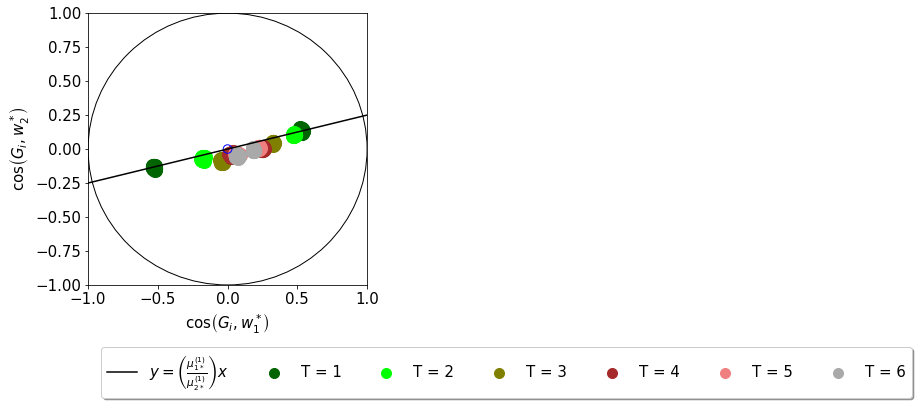

In [27]:
# Plot for different eta values the overlap matrix visualizing specialization 
colors = ['darkgreen', 'lime', 'olive',  'brown', 'lightcoral', 'darkgrey']
markers = ['o', 'v', '^', 's', 'd', 'p', '*', 'h']
for i in range(len(eta_vals)):
    cnt = -1
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    # plt.suptitle(r'Specialization for multiple GD steps. Learning rate fixed at $\eta$ = ' + str(eta_vals[i]))
    for t in range(max_gd_steps):
        if t>= 0:
            cnt += 1
            M = list_dict[f'list_t={t}'][i] 
            for j in range(len(M[:,0])):
                if j == 0:
                    ax.scatter(M[j,0], M[j,1], color = colors[cnt], label = f'T = {t+1}', s = 100)
                else:
                    ax.scatter(M[j,0], M[j,1], color = colors[cnt], s = 200)
    ax.plot(arr_to_plot,slope*arr_to_plot,color = 'black', label = r'$y = \left(\frac{\mu^{(1)}_{1*}}{\mu^{(1)}_{2*}}\right)x$') 
    # draw a circle centered in zero with radius 1
    circle = plt.Circle((0, 0), 1, color='black', fill=False)
    ax.add_artist(circle)
    # draw a circle centered in zero with radius 2/sqrt(d)
    circle = plt.Circle((0, 0), 2/np.sqrt(d), color='blue', fill=False)
    ax.add_artist(circle)
    ax.legend(fontsize = 15,loc='upper center', bbox_to_anchor=(1.5, -0.2),
          fancybox=True, shadow=True, ncol=15)
    ax.set_xlim([-1,1]) ; ax.set_ylim([-1,1]) 
    ax.set_xlabel(r'$\cos{\left(G_i,w^*_1\right)}$') 
    ax.set_ylabel(r'$\cos{\left(G_i,w^*_2\right)}$')
    # Increase size of the labels in the axis and thicks 
    ax.xaxis.label.set_size(15) ; ax.yaxis.label.set_size(15) 
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.show()


#### Example 2: Use linearly connected direction to escape from the spike $\vec{v}^*$

Consider the following Teacher-Student setting:
- Teachers: $\sigma_1^*(z) = z + z^2$ \& $\sigma_2^*(z) = z - z^2$  
- Student: $\sigma(z) = relu(z)$

In [28]:
 # Set teacher and student activation functions
stud_act = 'relu' 
teach_act1 = '2stair_pt1'
teach_act2 = '2stair_pt2'
f = stud_acts[stud_act]
fprime = stud_ders[stud_act]
f01 = teach_acts[teach_act1]
f02 = teach_acts[teach_act2] 
fnn0 = lambda D , W , a : 1/np.sqrt(p)*f(D@W.T)@a

# Get first hermite coeff of the chosen non-linearity
to_int1 = lambda z: f01(z) * z * gaussian(z,0,1)
fhc11 = quad(to_int1, -np.inf, np.inf)[0] 
to_int2 = lambda z: f02(z) * z * gaussian(z,0,1)
fhc12 = quad(to_int2, -np.inf, np.inf)[0]
# get predicted orientation 
slope = fhc12/fhc11 ; arr_to_plot = np.linspace(-1,1,10) 

# Choose what to save: gradients or weight matrices 
what_to_save = 'gradient'


Let's iterate for $T=6$ GD steps. 

In [30]:
list_dict = {} ; max_gd_steps = 6
for i,eta in enumerate(eta_vals):
   Wnew = W0 
   for t in range(max_gd_steps):
    Wold = Wnew
    list_name = f'list_t={t}'  # Generate the key name
    if i == 0:
      list_dict[list_name] = []  # Create an empty list with the key name
    to_app , Wnew , Gnew = gd_step(Wold,eta,what_to_save) 
    list_dict[list_name].append(to_app)  

Looking at the results we see: 
- We can predict the orientation of the gradient after one step as the ratio $ \vec{v}^* \propto \frac{\mu^{(1)}_{1*}}{\mu^{(1)}_{2*}}$. 
- We do have a linearly connected direction in the Hermite basis to $\vec{v}^*$, hence we can significantly move away from $\vec{v}^*$ as the training proceeds.

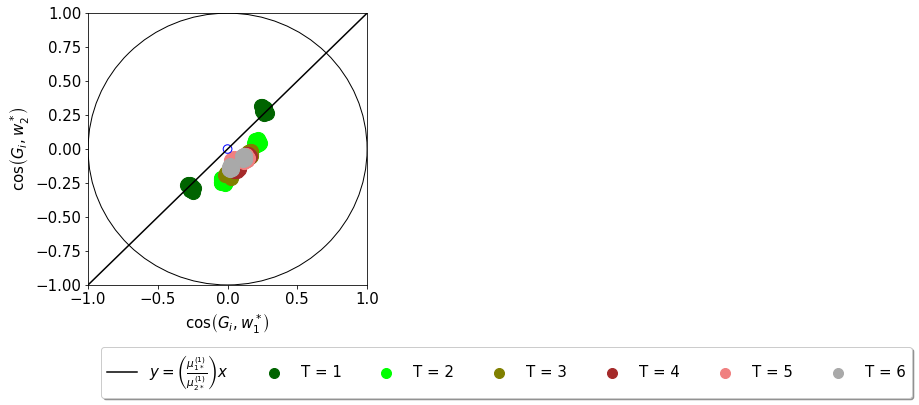

In [31]:
# Plot for different eta values the overlap matrix visualizing specialization 
colors = ['darkgreen', 'lime', 'olive',  'brown', 'lightcoral', 'darkgrey']
markers = ['o', 'v', '^', 's', 'd', 'p', '*', 'h']
for i in range(len(eta_vals)):
    cnt = -1
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    # plt.suptitle(r'Specialization for multiple GD steps. Learning rate fixed at $\eta$ = ' + str(eta_vals[i]))
    for t in range(max_gd_steps):
        if t>= 0:
            cnt += 1
            M = list_dict[f'list_t={t}'][i] 
            for j in range(len(M[:,0])):
                if j == 0:
                    ax.scatter(M[j,0], M[j,1], color = colors[cnt], label = f'T = {t+1}', s = 100)
                else:
                    ax.scatter(M[j,0], M[j,1], color = colors[cnt], s = 200)
    ax.plot(arr_to_plot,slope*arr_to_plot,color = 'black', label = r'$y = \left(\frac{\mu^{(1)}_{1*}}{\mu^{(1)}_{2*}}\right)x$') 
    # draw a circle centered in zero with radius 1
    circle = plt.Circle((0, 0), 1, color='black', fill=False)
    ax.add_artist(circle)
    # draw a circle centered in zero with radius 2/sqrt(d)
    circle = plt.Circle((0, 0), 2/np.sqrt(d), color='blue', fill=False)
    ax.add_artist(circle)
    ax.legend(fontsize = 15,loc='upper center', bbox_to_anchor=(1.5, -0.2),
          fancybox=True, shadow=True, ncol=15)
    ax.set_xlim([-1,1]) ; ax.set_ylim([-1,1]) 
    ax.set_xlabel(r'$\cos{\left(G_i,w^*_1\right)}$') 
    ax.set_ylabel(r'$\cos{\left(G_i,w^*_2\right)}$')
    # Increase size of the labels in the axis and thicks 
    ax.xaxis.label.set_size(15) ; ax.yaxis.label.set_size(15) 
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.show()
